In [ ]:
%load_ext autoreload
%autoreload 2


In [1]:
from sapy import Clock, ProgramCounter, MemoryAddressRegister, \
    RandomAccessMemory, SwitchBoard, RegisterA, RegisterB, RegisterOutput, \
    ArithmeticUnit, RegisterInstruction, Computer
import time

# Hex and Binary Literals in Python

In [ ]:
0xF

In [ ]:
0xFF

In [ ]:
print(15_000) # underscore as separators are allowed
print(0b1111_1111)

You can also format integers to HEX using X

In [ ]:
f"{132:X}"

# Clocking Signals

In [ ]:
clk = Clock()
class DummyComponent():
    def data(self, **kwargs):
        print("data accessed")
        return 42
    def clock(self, **kwargs):
        print("clock stepped")

dc = DummyComponent()
clk.add_component(dc)

In [ ]:
print("step 1: ---------")
clk.step()
print("step 2: ---------")
clk.step()

# Program Counter

To enable a component to take an action on a clock, you pass in the correct control bit as a keyword argument. To enable the PC to output to the data but, use the "ep" control bit.

In [ ]:
pc = ProgramCounter()

In [ ]:
pc.clock()
pc.data()

In [ ]:
pc.clock()
pc.data(ep=True)

In [ ]:
pc.clock()
pc.data(ep=True)

To increment the program counter, the control bit is "cp".

In [ ]:
pc.clock(cp=True)
pc.data(ep=True)

In [ ]:
pc.clock(cp=True)
pc.data(ep=True)

In [ ]:
pc.clock(cp=True)
pc.data(ep=True)

For jump instructions you set the program counter directly. This is done with the "lp" control bit.

In [ ]:
pc.clock(data=0xD, lp=True)
print(f"{pc.data(ep=True):X}")
print(f"{pc.data(ep=True)}")

# Accumulator (Register A)

In [ ]:
reg_a = RegisterA()
print(f"The register value on reset is: {reg_a.data(ea=True):X}")

reg_a.clock(data=0xAB, la=True)
reg_a.data(ea=True)
print(f"The register has latched a value: {reg_a.data(ea=True):X}")


# Adder

Some components have extra attributes that allow it to communicate directly to other components outside of the bus. 

The adder is not clocked, it doesn't even have state. The data output from the adder is alway the instantaneous sum (or difference) of Reg A + Reg B

In [ ]:
reg_a = RegisterA()
reg_a.clock(data=4, la=True)

reg_b = RegisterB()
reg_b.clock(data=3, lb=True)

adder = ArithmeticUnit(reg_a, reg_b)

assert adder.data() is None
adder.data(eu=True)


In [ ]:
reg_b.clock(data=1, lb=True)
adder.data(eu=True)

Subtraction

In [ ]:
adder.data(eu=True, su=True)

# Memory

Ram is another example of a system that has communication outside the bus, it always access the RAM value stored at the address latched in the Memory Address Register.

In [ ]:
mar = MemoryAddressRegister()
ram = RandomAccessMemory(mar)

# store address for ram in register
mar.clock(data=0xF, lm=True)
print(f"Memory Address: {mar.address():X}")

# clock data into ram at the address set above
ram.clock(data=0xAB, lr=True)
assert ram.data() == None
print(f"Memory at address: {mar.address():X} is {ram.data(er=True):X}") # should be 0xAB
print(f"Memory at address: {mar.address()} is {ram.data(er=True)}") # just to demystfy hex..

# Controller: Sequencer + Decoder + Clock

In [ ]:
reg_i = RegisterInstruction()
instruction = 0xFF # both opcode and argument, 8bits
reg_i.clock(data=instruction, li=True)


In [ ]:
print(f"The opcode is {reg_i.opcode():X}")

# Example Sequencing: LDA

In [ ]:
from sapy import Computer

cpu = Computer()
rom = [
    0x00, 0x09, # 0x0 LDA 09H
    ]
cpu.switches.load_program(rom)

for _ in range(7):
    cpu.step(debug=True) 

In [ ]:
cpu.step(debug=True)

# Output (Register O)

In [ ]:
reg_o = RegisterOutput()
reg_o.clock(data=0x90, lo=True)


In [ ]:
# monkey patch output function for fancy display
def display_number(x):
    print(f"***### {x} ###***")
reg_o.output_function = display_number

In [ ]:
reg_o.clock(data=0x90, lo=True)

# Full Computer with ROM

In [ ]:
cpu = Computer()
rom = [
    0x00, 0x07, # 0x00 LDA 07H
    0x01, 0x08, # 0x02 ADD 08H
    0x03,       # 0x04 OUT
    0x04, 0x02, # 0x05 JMP 02H
    0x00,       # 0x07 A1H
    0x03,       # 0x08 22H
    ]
cpu.switches.load_program(rom)

In [ ]:
for _ in range(9):
    cpu.step(instructionwise=True)

In [ ]:
for _ in range(3):
    cpu.step(instructionwise=True, debug=True)

In [ ]:
import ipywidgets as widgets
from IPython.display import display
gui_output_display = widgets.FloatText()
display(gui_output_display)

# monkey patch output function
def display_number(x):
    gui_output_display.value = x

cpu.reg_o.output_function = display_number

In [ ]:
for _ in range(3):
    time.sleep(.2)
    cpu.step(instructionwise=True, debug=False)

In [ ]:
for _ in range(27):
    time.sleep(.03)
    cpu.step(instructionwise=True, debug=False)

In [ ]:
while True:
    time.sleep(.03)
    cpu.step(instructionwise=True, debug=False)

In [ ]:
cpu = Computer()
rom = [
    0x00, 0x09, # 0x00 LDA 09H
    0x01, 0x0A, # 0x20 ADD 0AH
    0x03,       # 0x04 OUT
    0x05, 0x0A, # 0x05 STA 0AH
    0x04, 0x02, # 0x07 JMP 02H
    0x01,       # 0x09 01H
    0x02,       # 0x0A 02H
    ]

cpu.switches.load_program(rom)
#cpu.reset()

In [ ]:
import ipywidgets as widgets
from IPython.display import display
gui_output_display = widgets.FloatText()
display(gui_output_display)

# monkey patch output function
def display_number(x):
    gui_output_display.value = x

cpu.reg_o.output_function = display_number

In [ ]:
while True:
    time.sleep(.2)
    cpu.step(instructionwise=True, debug=True)

In [ ]:
cpu.step(instructionwise=True, debug=True)

# DMA

In [4]:
%matplotlib notebook

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
pc = Computer()
program = [
    0x10, 0x09, # 0x00 LDA 09H
    0x11, 0x0A, # 0x20 ADD 0AH
    0x0D,       # 0x04 OUT
    0x15, 0x0A, # 0x05 STA 0AH
    0x14, 0x02, # 0x07 JMP 02H
    0x00,       # 0x09 A1H
    0x02,       # 0x0A 22H
    ]
pc.switches.load_program(program)

<IPython.core.display.Javascript object>


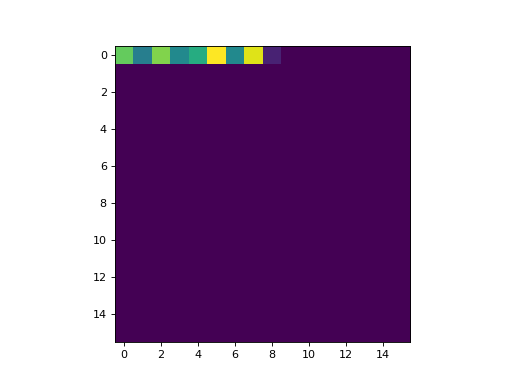

In [7]:
fig, ax = plt.subplots(1,1)
def plt_memory(bitmap):
    ax.imshow(bitmap)
    fig.canvas.draw()
pc.dma.connect_dma_handler(plt_memory)

In [172]:
pc.step()

T1: Data: 20, Control Word: ('er', 'li')
